In [1]:
import numpy as np
import os
import torch
from misc.example_helper import *
import importlib
import processing
import models
%load_ext autoreload
%autoreload 2
importlib.reload(processing)
importlib.reload(models)
from processing.data_manager import SHREDDataManager
from processing.parametric_data_manager import ParametricSHREDDataManager
from models.shred_models import SHRED
from models.shred_models import evaluate

In [ ]:
import os

# Initialize SHREDDataManager
manager = SHREDDataManager(
    lags = 20,
    train_size = 0.6,
    val_size = 0.2,
    test_size = 0.2,
    scaling = "minmax",
    compression = 20,
    time=np.arange(0, 2000),
    method="all"
)


# Add data to manager (no sensors)
input_folder = "data4fields_npz"
for filename in os.listdir(input_folder):
    print('filename',filename)
    if filename.endswith(".npz") and filename != 'ni_3D.npz':
        file_path = os.path.join(input_folder, filename)
        manager.add(
            data=file_path,
            id = str(os.path.splitext(filename)[0]),
            random_sensors=1,
        )
        print(f"Processed: {filename}")


# Add data to manager (with sensors)
filename = 'ni_3D.npz'
file_path = os.path.join(input_folder, filename)
ni_3D = np.load(file_path)
ni_3D = ni_3D[ni_3D.files[0]]
mobile_sensors = [
    perimeter_walk(height = ni_3D.shape[1], width = ni_3D.shape[2], timesteps = ni_3D.shape[0], clockwise=True),
    perimeter_walk(height = ni_3D.shape[1], width = ni_3D.shape[2], timesteps = ni_3D.shape[0], clockwise=False)
]
manager.add(
    data=ni_3D,
    random_sensors=3,
    # stationary_sensors=[(7, 9), (0,0)],
    # mobile_sensors=mobile_sensors,
    id = str(os.path.splitext(filename)[0])
)


filename Jex_3D.npz
n_components 20
V.shape (20, 65792)
compressed full_state_data: (2000, 20)
self.full_state_data pre transform (2000, 65792)
transformed_data_std_scale (2000, 65792)
transformed_data (2000, 20)
n_components 20
V.shape (20, 65792)
compressed full_state_data: (2000, 20)
self.full_state_data pre transform (2000, 65792)
transformed_data_std_scale (2000, 65792)
transformed_data (2000, 20)
Processed: Jex_3D.npz
filename Jey_3D.npz
n_components 20
V.shape (20, 65792)
compressed full_state_data: (2000, 20)
self.full_state_data pre transform (2000, 65792)
transformed_data_std_scale (2000, 65792)
transformed_data (2000, 20)
n_components 20
V.shape (20, 65792)
compressed full_state_data: (2000, 20)
self.full_state_data pre transform (2000, 65792)
transformed_data_std_scale (2000, 65792)
transformed_data (2000, 20)
Processed: Jey_3D.npz
filename Jez_3D.npz
n_components 20
V.shape (20, 65792)
compressed full_state_data: (2000, 20)
self.full_state_data pre transform (2000, 65792)


In [3]:
manager.input_summary

,field id,sensor id,sensor type,location/trajectory
0,Jex_3D,Jex_3D-0,stationary (randomly selected),"(74, 61)"
1,Jey_3D,Jey_3D-0,stationary (randomly selected),"(216, 160)"
2,Jez_3D,Jez_3D-0,stationary (randomly selected),"(13, 38)"
3,ni_3D,ni_3D-0,stationary (randomly selected),"(154, 23)"
4,ni_3D,ni_3D-1,stationary (randomly selected),"(93, 188)"
5,ni_3D,ni_3D-2,stationary (randomly selected),"(192, 240)"


In [4]:
manager.sensor_measurements

,time,Jex_3D-0,Jey_3D-0,Jez_3D-0,ni_3D-0,ni_3D-1,ni_3D-2
0,0,617.170,163.660,-1059.2,4.396600e+16,5.045500e+16,4.929000e+16
1,1,59.261,-154.610,-3947.8,4.474700e+16,5.003000e+16,4.895200e+16
2,2,-32.520,85.413,-4007.4,4.704700e+16,5.148200e+16,4.799100e+16
3,3,-3.173,-20.815,-3763.7,4.926600e+16,5.289500e+16,4.808000e+16
4,4,56.287,-171.540,-3964.5,5.313300e+16,5.488100e+16,5.198200e+16
...,...,...,...,...,...,...,...
1995,1995,384.450,-829.420,-3997.0,1.067000e+17,1.221600e+17,1.161300e+17
1996,1996,768.130,-323.860,-3698.4,1.133700e+17,1.154700e+17,1.047400e+17
1997,1997,1239.100,-66.261,-3512.0,1.182400e+17,1.119000e+17,1.012800e+17
1998,1998,1502.900,279.750,-3516.9,1.299400e+17,1.105700e+17,9.509300e+16


In [ ]:
# Get train/valid/test datasets
train_set, valid_set, test_set = manager.preprocess()

# Print dataset shapes
print('Data Shapes:')
print ('Random Reconstructor Data')
print('train X:', train_set.reconstructor_dataset.X.shape)
print('train Y:', train_set.reconstructor_dataset.Y.shape)
print('valid X:', valid_set.reconstructor_dataset.X.shape)
print('valid Y:', valid_set.reconstructor_dataset.Y.shape)
print('test X:', test_set.reconstructor_dataset.X.shape)
print('test Y:', test_set.reconstructor_dataset.Y.shape)

print ('Temporal Reconstructor Data')
print('train X:', train_set.predictor_dataset.X.shape)
print('train Y:', train_set.predictor_dataset.Y.shape)
print('valid X:', valid_set.predictor_dataset.X.shape)
print('valid Y:', valid_set.predictor_dataset.Y.shape)
print('test X:', test_set.predictor_dataset.X.shape)
print('test Y:', test_set.predictor_dataset.Y.shape)



print ('Sensor Forecaster Data')
print('train X:', train_set.sensor_forecaster_dataset.X.shape)
print('train Y:', train_set.sensor_forecaster_dataset.Y.shape)
print('valid X:', valid_set.sensor_forecaster_dataset.X.shape)
print('valid Y:', valid_set.sensor_forecaster_dataset.Y.shape)
print('test X:', test_set.sensor_forecaster_dataset.X.shape)
print('test Y:', test_set.sensor_forecaster_dataset.Y.shape)

Data Shapes:
Random Reconstructor Data
train X: torch.Size([1200, 21, 6])
train Y: torch.Size([1200, 80])
valid X: torch.Size([400, 21, 6])
valid Y: torch.Size([400, 80])
test X: torch.Size([400, 21, 6])
test Y: torch.Size([400, 80])
Temporal Reconstructor Data
train X: torch.Size([1200, 21, 6])
train Y: torch.Size([1200, 80])
valid X: torch.Size([400, 21, 6])
valid Y: torch.Size([400, 80])
test X: torch.Size([400, 21, 6])
test Y: torch.Size([400, 80])
Sensor Forecaster Data
train X: torch.Size([1200, 21, 6])
train Y: torch.Size([1200, 6])
valid X: torch.Size([400, 21, 6])
valid Y: torch.Size([400, 6])
test X: torch.Size([400, 21, 6])
test Y: torch.Size([400, 6])


In [ ]:
# manager.postprocess(test_set.predictor_dataset.Y.detach().cpu().numpy())

In [7]:
print("Verify forecaster train set...")
print(torch.all(train_set.sensor_forecaster_dataset.X[1:, -1, :] == train_set.sensor_forecaster_dataset.Y[:-1, :]))
print("Verify forecaster valid set...")
print(torch.all(valid_set.sensor_forecaster_dataset.X[1:, -1, :] == valid_set.sensor_forecaster_dataset.Y[:-1, :]))
print("Verify forecaster test set...")
print(torch.all(test_set.sensor_forecaster_dataset.X[1:, -1, :] == test_set.sensor_forecaster_dataset.Y[:-1, :]))

Verify forecaster train set...
tensor(True)
Verify forecaster valid set...
tensor(True)
Verify forecaster test set...
tensor(True)


In [8]:
# initialize SHRED
shred = SHRED(sequence='LSTM', decoder='SDN')
# fit SHRED
valid_errors = shred.fit(train_set, valid_set, num_epochs=1000, patience=20, verbose=True)

Newest Version
input_size 6
output_size 80
self._sequence_model_random_reconstructor.output_size 64

Fitting Random Reconstructor...


Epoch 69/1000: 100%|██████████| 19/19 [00:00<00:00, 100.35batch/s, loss=0.000373, L2=0.0357, val_loss=4.64e-5, val_L2=0.0126]


Early stopping triggered: patience threshold reached.
input_size 6
output_size 80
self._sequence_model_temporal_reconstructor.output_size 64

Fitting Temporal Reconstructor...


Epoch 54/1000: 100%|██████████| 19/19 [00:00<00:00, 102.95batch/s, loss=0.00034, L2=0.0348, val_loss=1.91e-5, val_L2=0.00827]


Early stopping triggered: patience threshold reached.
input_size 6
output_size 6

Fitting Sensor Forecaster...


Epoch 178/1000: 100%|██████████| 19/19 [00:00<00:00, 99.63batch/s, loss=0.00104, L2=0.0645, val_loss=0.0012, val_L2=0.0658] 


Early stopping triggered: patience threshold reached.


In [9]:
# evaluate(shred = shred, test_dataset=test_set, data_manager=manager, inverse_transform = True)
evaluate(shred = shred, test_dataset=test_set, data_manager=manager, uncompress=True, unscale = True)

method random_reconstructor
(400, 20)
unflattend
method random_reconstructor
(400, 20)
unflattend
method random_reconstructor
(400, 20)
unflattend
method random_reconstructor
(400, 20)
unflattend
method random_reconstructor
(400, 20)
unflattend
method random_reconstructor
(400, 20)
unflattend
method random_reconstructor
(400, 20)
unflattend
method random_reconstructor
(400, 20)
unflattend
method temporal_reconstructor
(400, 20)
unflattend
method temporal_reconstructor
(400, 20)
unflattend
method temporal_reconstructor
(400, 20)
unflattend
method temporal_reconstructor
(400, 20)
unflattend
method temporal_reconstructor
(400, 20)
unflattend
method temporal_reconstructor
(400, 20)
unflattend
method temporal_reconstructor
(400, 20)
unflattend
method temporal_reconstructor
(400, 20)
unflattend
sensor_forecaster_prediction_shape (421, 6)
lagged_sensor_forecaster_prediction torch.Size([400, 21, 6])
method temporal_reconstructor
(400, 20)
unflattend
method temporal_reconstructor
(400, 20)
unfl

,Jex_3D,Jey_3D,Jez_3D,ni_3D
random reconstructor,62.308368,62.941949,16.216100,686428.735665
temporal reconstructor,65.077495,40.186001,13.919061,445035.011675
forecaster,64.800618,40.149054,13.912565,445976.290115
sensor forecaster,0.064213,NaN,NaN,NaN


In [10]:
# evaluate(shred = shred, test_dataset=test_set, data_manager=manager, inverse_transform = True)
evaluate(shred = shred, test_dataset=test_set, data_manager=manager, uncompress=False, unscale = False)

sensor_forecaster_prediction_shape (421, 6)
lagged_sensor_forecaster_prediction torch.Size([400, 21, 6])


,Jex_3D,Jey_3D,Jez_3D,ni_3D
random reconstructor,0.012581,0.013074,0.012166,0.012780
temporal reconstructor,0.008793,0.008266,0.008293,0.008234
forecaster,0.008774,0.008239,0.008276,0.008228
sensor forecaster,0.064213,NaN,NaN,NaN


In [ ]:
shred.reconstructor(data)
shred.predictor()

In [14]:
manager.data_processors[0].scaler

{'random_reconstructor': MinMaxScaler(),
 'temporal_reconstructor': MinMaxScaler()}

In [ ]:
test_set.reconstructor_dataset

In [ ]:
prediction = shred.reconstructor(test_set.reconstructor_dataset.X).detach().cpu().numpy()
prediction.shape

(400, 80)

In [ ]:
dataset_dict = manager.postprocess(prediction, uncompress = True, unscale = True, method = 'reconstructor')
true_dataset_dict = manager.postprocess(test_set.reconstructor_dataset.Y.numpy(),  uncompress = True, unscale = True, method = 'reconstructor')

method random_reconstructor
(400, 20)
unflattend
method random_reconstructor
(400, 20)
unflattend
method random_reconstructor
(400, 20)
unflattend
method random_reconstructor
(400, 20)
unflattend
method random_reconstructor
(400, 20)
unflattend
method random_reconstructor
(400, 20)
unflattend
method random_reconstructor
(400, 20)
unflattend
method random_reconstructor
(400, 20)
unflattend


In [13]:
dataset_dict['ni_3D'].shape

(400, 257, 256)

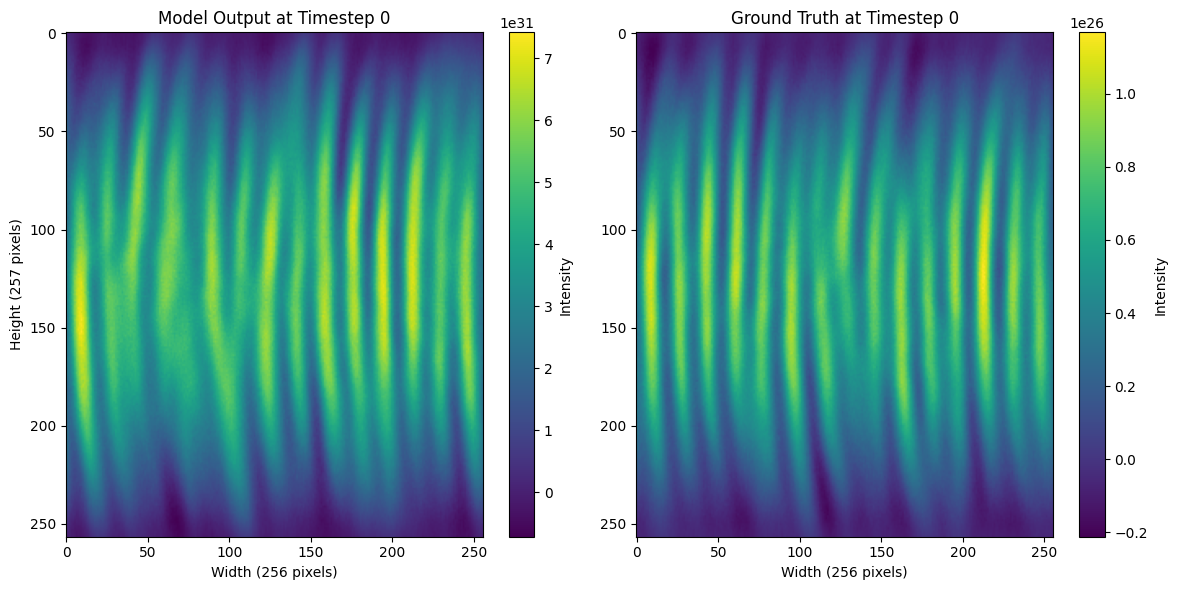

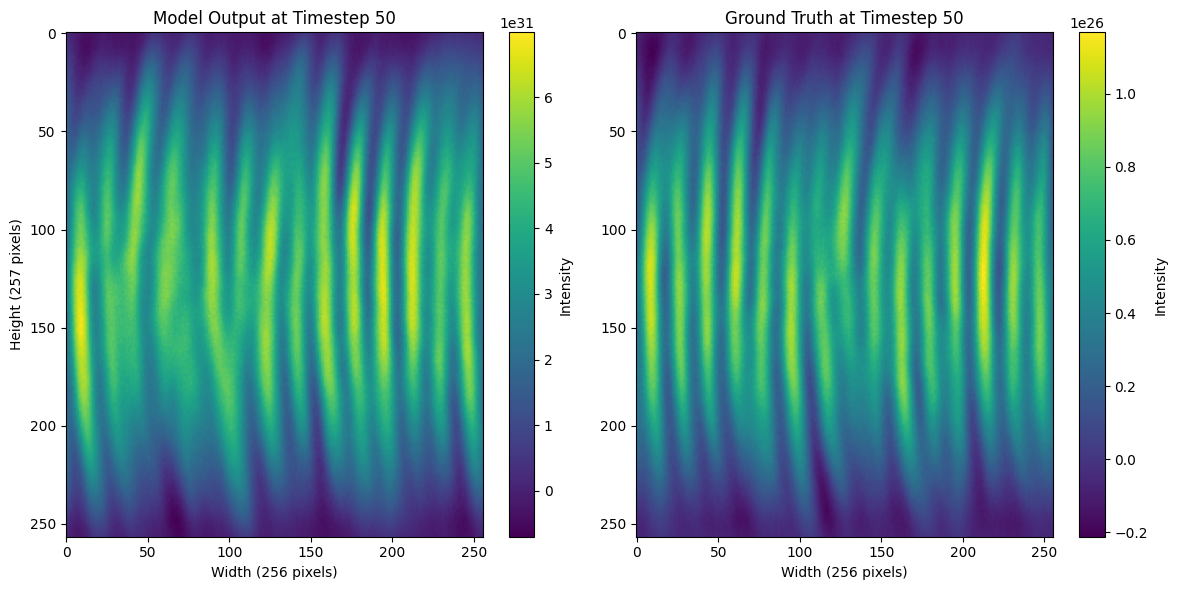

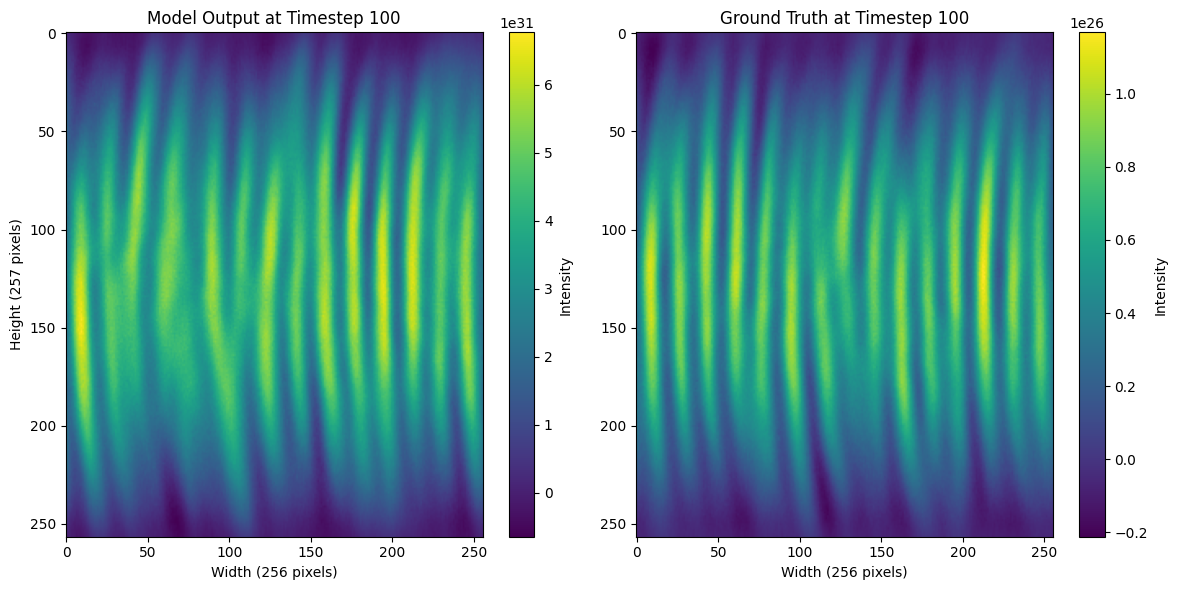

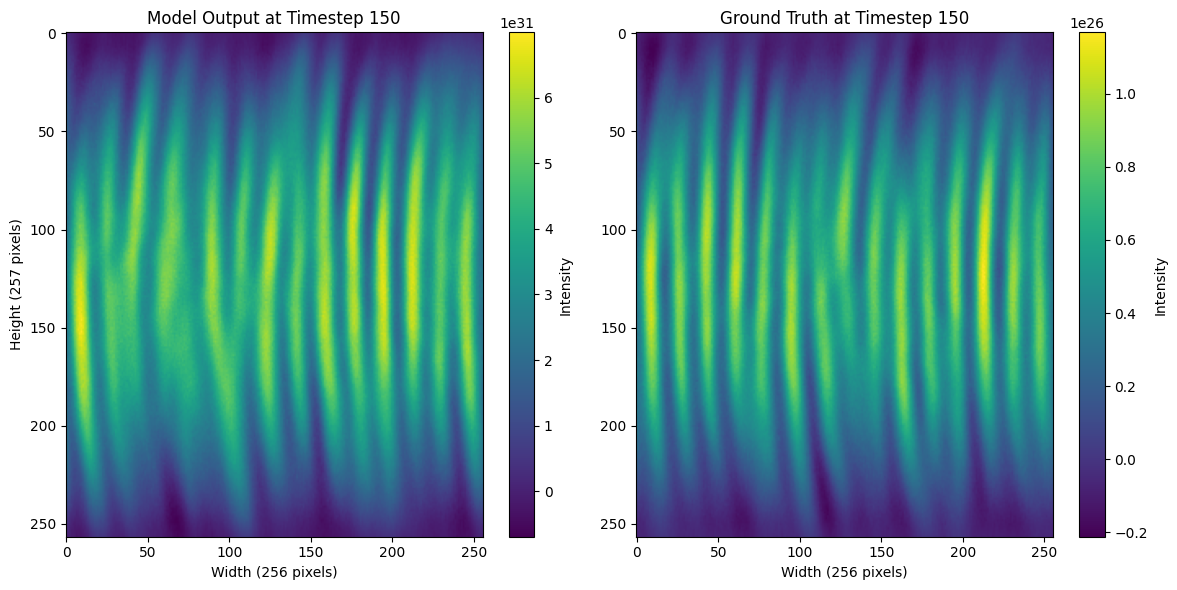

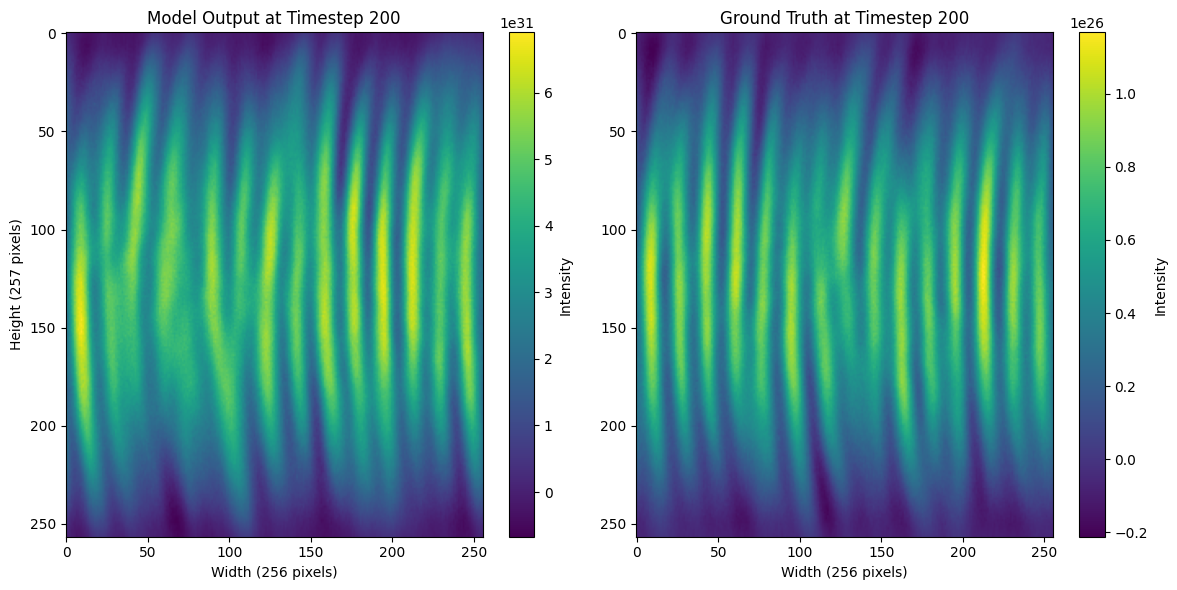

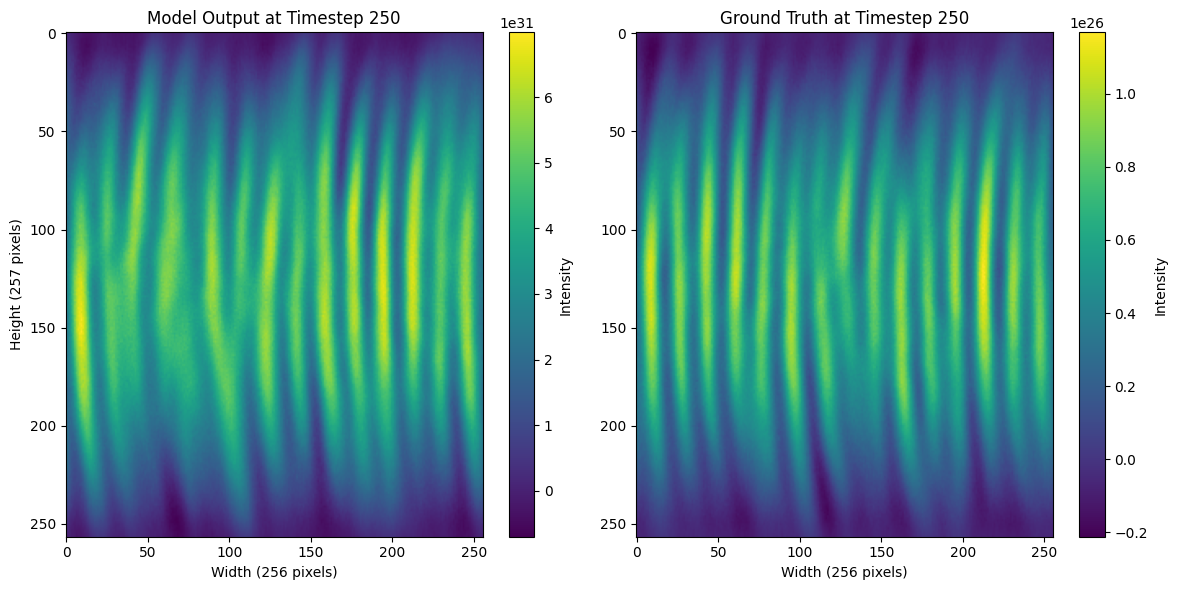

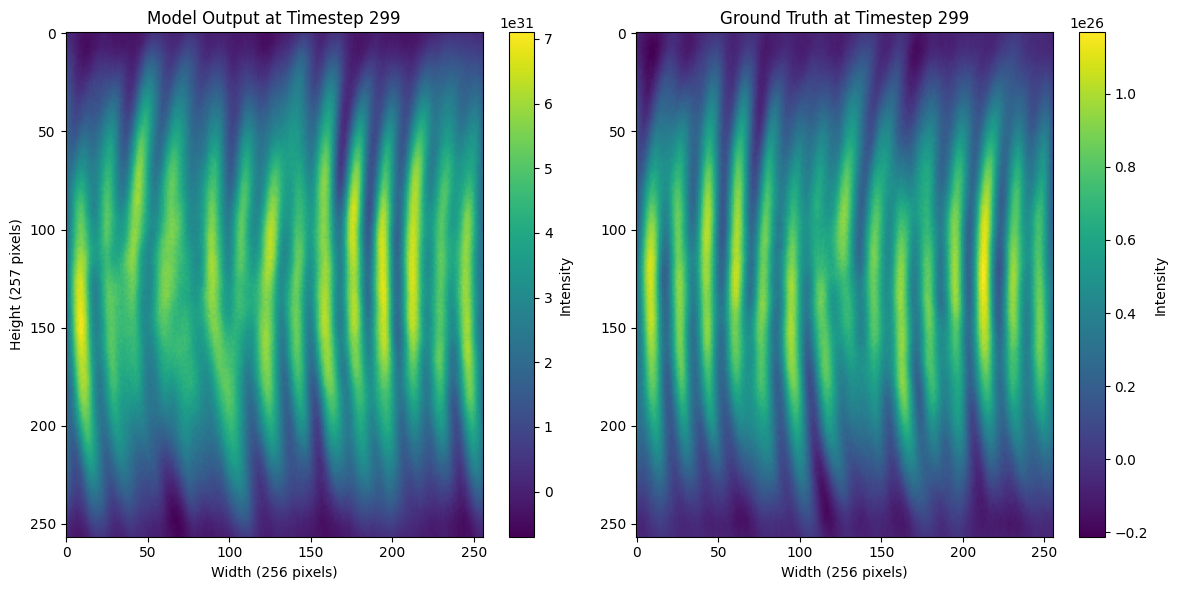

In [14]:
timesteps = [0,50,100,150,200,250,299]
for t in timesteps:
    plot_frame_comparison(dataset_dict['ni_3D'], true_dataset_dict['ni_3D'], timestep=t)  # Plot frame at timestep 100

In [339]:
fake_new_measurements = manager.generate_X(measurements=all_sensor_measurements)

In [340]:
fake_new_measurements.shape

torch.Size([2000, 21, 15])

In [332]:
# print(test_set.forecaster.Y.shape)
# fake = test_set.forecaster.Y[0:5,:]
# print(fake.shape)

time = np.arange(2020,2221)
fake = test_set.forecaster.Y[0:len(time),:]


# sensor_measurements_for_prediction = manager.generate_X(start = 2006, end = 2020, measurements = fake, time = time, forecaster=shred._sensor_forecaster)
sensor_measurements_for_prediction = manager.generate_X(start = 1999, end = 2000, forecaster=shred._sensor_forecaster)
sensor_measurements_for_prediction.shape

hello
hello
hello
hello
[[0.40742986 0.47897545 0.41693697 ... 1.         0.25157183 0.2098888 ]
 [0.42120873 0.50244979 0.42059753 ... 0.9243055  0.21881721 0.19440032]
 [0.41494846 0.4995862  0.41595162 ... 0.86197133 0.16993708 0.14810661]
 ...
 [0.43287099 0.45942148 0.45248675 ... 0.41218788 0.37016986 0.0893137 ]
 [0.42210832 0.46894794 0.41789372 ... 0.44039766 0.37288314 0.07896658]
 [       nan        nan        nan ...        nan        nan        nan]]


torch.Size([2, 21, 15])

In [ ]:
sensor_measurements_for_prediction.shape

torch.Size([22, 21, 15])

In [253]:
full_state_for_new_sensor_measurements = shred(sensor_measurements_for_prediction)

Newest Version


In [ ]:
full_state_for_new_sensor_measurements.shape

torch.Size([22, 80])

In [ ]:
sensor_measurements_for_prediction.shape

torch.Size([2021, 15])